# Numerical exercises 06

From shell, inside `/code` directory:
- To compile: `make`;

From shell, inside _this_ directory:
- To run the first program: `./equilibration.sh`;
- To run the second program (it takes a while): `./ex1.sh`.

The scripts provided should take care of everything. The scripts set also the values of the input file. To change the input values the best option could be to modify the scripts themselves. The two programs are independent and can be executed in whatever order.

In [184]:
import numpy as np
from numpy import tanh, cosh, sinh, exp, sqrt
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes    # zoomed up image libraries
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.style as style 
style.use('tableau-colorblind10')

## Exercise 06.1: Ising Model simulation with Metropolis and Gibbs sampling

### Sampling the canonical ensemble probability distribution

The simulations of the molecular dynamics done in exercise 04 were performed in the microcanonical ensemble. In it, equilibrium states are identified by a collection of fixed extensive variables: the number of degrees of freedom $N$, the volume $V$, the internal energy $E$. Experimental constraints often make preferable a different choice. In particular, in the **canonical ensemble** the number of degrees of freedom $N$, the volume $V$, and the **temperature** $T$ are fixed. The thermodynamics of this system can be derived by the knowledge of the partition function or of the (Helmoltz) free energy associated to the ensemble $A = E -TS$:
$$
Q_N(V,T)=e^{-A(N,V;T)/k_B T} \quad \quad A(N,V,T) = -k_B T \ln Q_N(V,T)
$$
Calculating any thermodynamic property $\langle f \rangle$ with MC methods seems to be an impossible task without this knowledge:
$$
\langle f \rangle = \int \frac{d^{3N}q d^{3N} p}{h^{3N} N!} f(\vec q, \vec p ) \frac{ e^{-H(\vec q, \vec p)/k_B T}}{Q_N(V,T)},
$$
But with Metropolis algorithm we can in fact sample the probability distribution:
$$
\rho(\vec q, \vec p) = \frac{e^{-H(\vec q, \vec p)/k_B T}}{Q_N(V,T)}
$$
without knowing the normalization constant, that goes away in the acceptance step. 

### The Ising Model

In the simulation, we deal with a one-dimensional Ising model made up by $N=50$ spin degrees of freedom ($\pm 1$ are the only possible values) $\{s_i\}_{i=1}^N$, with periodic boundary condition: $s_{N+1}=s_1$. The Ising model is exactly resoluble, and its hamiltonian is given by, with $\mu_B=1$ and $k_B=1$:
$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}),
$$
where $J$ is the coupling between nearest neighbors: at low enough temperatures, for positive values of $J$ the spins tend to orient themselves in the same direction (ferromagnetic behavior), for negative values they tend to orient themselves in opposite directions (anti-ferromagnetic behavior); $h$ is the external magnetic field.

The partition function is given by a sum over all of the possible spin configurations:
$$
Q_N=\sum_{\{s_i\}} e^{-\beta H} = \lambda_1^N + \lambda_2^N, 
$$
with:
$$
\lambda_{1,2} = 
e^{\beta J} 
\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}
$$

This is all we need to compute the analytical value of the thermodynamics quantities of interest. We define them in the cell below: we will use them to compare their theoretical value with the results from our simulations.

In [ ]:
J,Ns = 1.0,50        #J, number of spins
h=0.02 #external field

#generating theorecal curves
points=100
Tlin = np.linspace(0.2,3.0,num=points)
b = 1/Tlin
th = tanh(J/Tlin)
thN= th**Ns
ch = 1/th
#predicted energy
ene = -J*( th + ch*thN )/( 1 + thN )
#predicted heat capacity
heat=((b*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
#compute predicted magnetisation (h!=0)
l1 = exp(b*J)*cosh(b*h)+sqrt(exp(2*b*J)*cosh(b*h)*cosh(b*h)-2*sinh(2*b*J))
l2 = exp(b*J)*cosh(b*h)-sqrt(exp(2*b*J)*cosh(b*h)*cosh(b*h)-2*sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (exp(b*J)*sinh(b*h)*((l1**(Ns-1))*(1+exp(b*J)*cosh(b*h)/sqrt(exp(2*b*J)*cosh(b*h)*cosh(b*h)-2*sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-exp(b*J)*cosh(b*h)/sqrt(exp(2*b*J)*cosh(b*h)*cosh(b*h)-2*sinh(2*b*J)))))/(Z)
#predicted susceptibility
X = b*exp(2*b*J)*(1-thN)/(1+thN)

obs_teo=(ene,heat,X,M)
title_obs=('Internal energy per particle','Specific heat per particle','Magnetic suscettivity','Magnetization per particle')

We will compare the theoretical results with the Monte Carlo outputs making use of the following relations:

$$ U(N,T,h) = \langle H \rangle $$

$$ C(N,T,h) = \frac{\partial U(N,T)}{\partial T} = \beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right) $$

$$ M(N,T,h) = k_B T \frac{\partial \ln Z}{\partial h} =
\left\langle \sum_{i=1}^N s_i \right\rangle $$

$$ \chi(N,T,h) = \frac{\partial M}{\partial h} =
\beta \left[ \left\langle \left( \sum_{i=1}^N s_i \right)^2 \right\rangle - \left\langle \sum_{i=1}^N s_i \right\rangle^2 \right] $$

### Metropolis & Gibbs sampling

The Metropolis algorithm will be used to sample the Boltzmann density probability:
$$
\rho = \frac{e^{-\beta H}}{Q},
$$
for our system of $50$ spins at $T$ fixed. This probability will be used to compute the expectation values.

Furthermore, we can directly sample the conditioned probability of a specific degree of freedom $s_k$, at fixed values of the other spins (that form a heat bath). From the theory we get:
$$
p_{1|(N-1)}\left(s_k=\pm 1\ |\ {\{ s_j\}_{j \neq k}}\right) =
\frac{1}{ 1 + exp\{\mp\ 2 \beta \left[ J \left(s_{k-1}+s_{k+1} \right) + h \right] \}}
$$
We can therefore apply also the Gibbs sampling, a special case of Metropolis algorithm that accepts each of the proposed moves.

In [190]:
J,Ns = 1.0,50        #J, number of spins
h=0.02 #external field

nburn=5000
T=(0.5,0.95,2.)
eteo=[-J*( (tanh(J/t)) + (1/(tanh(J/t)))*((tanh(J/t))**Ns) )/( 1 + ((tanh(J/t))**Ns) )*Ns for t in T]
title=('First 500 points','last 1000 points'); labteo=['expected <U>','','']

def graph_burn(ifMetro, iffield):
    if ifMetro: name="metropolis"
    else: name="gibbs"
    
    if iffield: field="0.02"
    else: field="0"

    burn1=np.genfromtxt('equilibration/'+name+'/'+field+'/0.5/results_eq/instant.ene.0',names='x,u')
    burn2=np.genfromtxt('equilibration/'+name+'/'+field+'/0.95/results_eq/instant.ene.0',names='x,u')
    burn3=np.genfromtxt('equilibration/'+name+'/'+field+'/2.0/results_eq/instant.ene.0',names='x,u')
    burn=(burn1,burn2,burn3); labT=['T='+str(temp) for temp in T]
    
    pl.figure(figsize=(15,4))
    for i in range(2):
        pl.subplot(1,2,i+1)
        for j in range(3): pl.plot(burn[j]['x'],burn[j]['u'],label=labT[j])
        for j in range(3): pl.axhline(y=eteo[j],color='k',linewidth=0.8,label=labteo[j])
        if i==0: pl.xlim(-1,200)
        elif i==1: pl.xlim(nburn-500,nburn)
        if(i==0): pl.legend(loc='center left', bbox_to_anchor=(0, 1.35))
        pl.xlabel('$N_{burn}$')
        if i==0: pl.ylabel('$U$',labelpad=15)
        pl.title(title[i])
        pl.grid(True)
    pl.suptitle('Burn in, '+name+' sampling')
    pl.show()

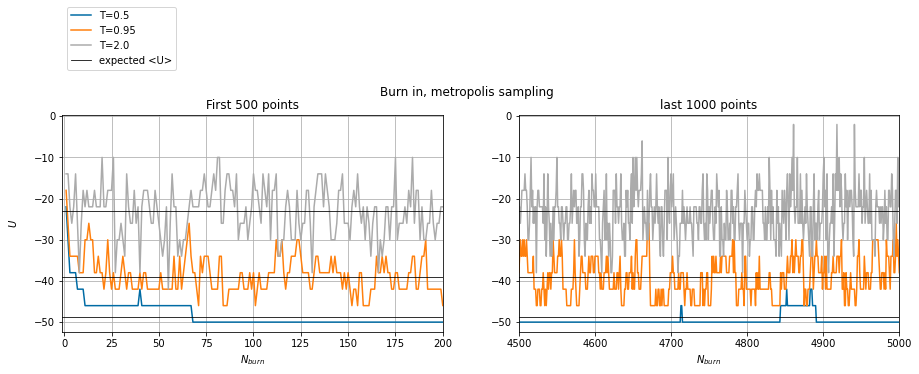

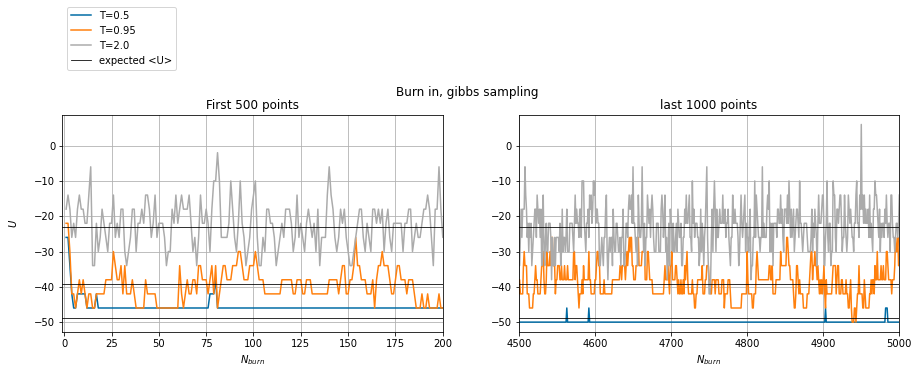

In [191]:
graph_burn(True, False)
graph_burn(False, False)

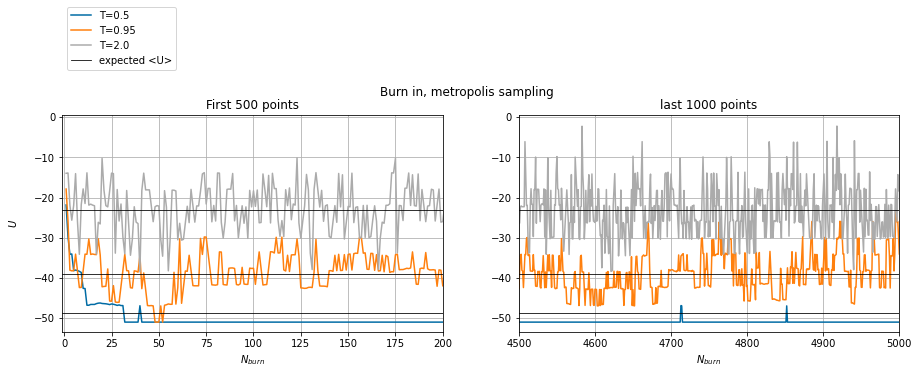

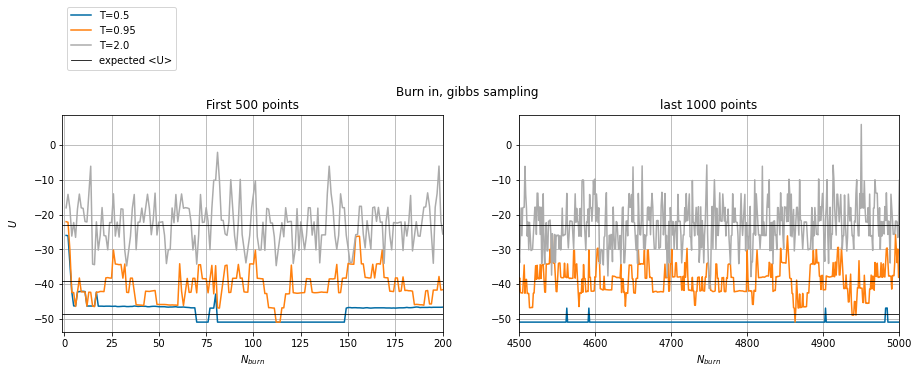

In [192]:
graph_burn(True, True)
graph_burn(False, True)

In [180]:
def obs_graph(obs_name):
    if obs_name=='ene': obs_ind=0; ylab='U'
    elif obs_name=='heat': obs_ind=1; ylab='C' 
    elif obs_name=='chi': obs_ind=2; ylab='\chi'
    elif obs_name=='mag': obs_ind=3; ylab='M'
    
    namefolder='ex6.1/'
    metro=np.genfromtxt(namefolder+'/metropolis/'+obs_name+'.dat',names='T,res,err')
    gibbs=np.genfromtxt(namefolder+'/gibbs/'+obs_name+'.dat',names='T,res,err')
    obs=(metro,gibbs); label=('Metropolis','Gibbs')
    
    fig,ax=pl.subplots(figsize=(12,6))
    for i in range(2): pl.errorbar(obs[i]['T'],obs[i]['res'],yerr=obs[i]['err'],label=label[i])
    pl.plot(Tlin,obs_teo[obs_ind],color='k',linewidth=0.8,label='expected $<'+ylab+'/N>$')
    pl.xlim(0.4,2.1)
    if obs_name=="chi": pl.ylim(-10,140)
    pl.legend(loc='best')
    pl.xlabel('$T$')
    pl.ylabel('$'+ylab+'/N\ (T)$',labelpad=15)
    pl.title(title_obs[obs_ind])
    pl.grid(True)
    
    if obs_name=="heat":    #zoomed part for heat
        axins=zoomed_inset_axes(ax,2.8,loc=8)   # axes instance zoomed, zoom and position
        for i in range(2): axins.errorbar(obs[i]['T'],obs[i]['res'],yerr=obs[i]['err'])
        axins.plot(Tlin,obs_teo[obs_ind],color='k',linewidth=0.8)
        axins.set_xlim(0.52,0.92)
        axins.set_ylim(0.38,0.46)
        pl.grid(True)
        pl.yticks(visible=False)
        pl.xticks(visible=False)
        mark_inset(ax,axins,loc1=1,loc2=3,fc='none',ec='0.6')
        
    if obs_name=="chi":    #zoomed part for chi
        axins=zoomed_inset_axes(ax,2.8,loc='center right')   # axes instance zoomed, zoom and position
        for i in range(2): axins.errorbar(obs[i]['T'],obs[i]['res'],yerr=obs[i]['err'])
        axins.plot(Tlin,obs_teo[obs_ind],color='k',linewidth=0.8)
        axins.set_xlim(0.58,0.8)
        axins.set_ylim(15,45)
        pl.grid(True)
        pl.yticks(visible=False)
        pl.xticks(visible=False)
        mark_inset(ax,axins,loc1=1,loc2=3,fc='none',ec='0.6')
    
    pl.show()

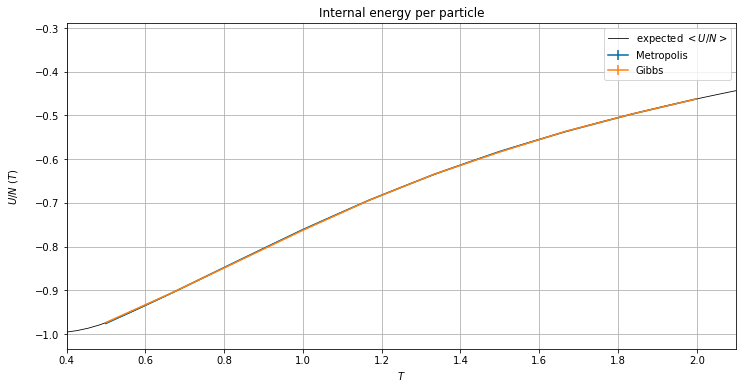

In [152]:
obs_graph("ene")

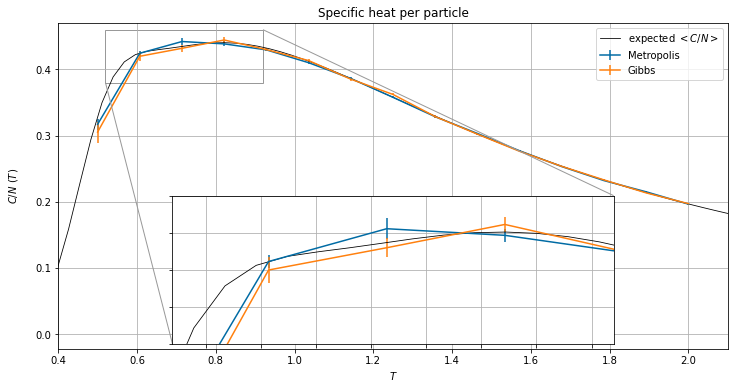

In [157]:
obs_graph("heat")

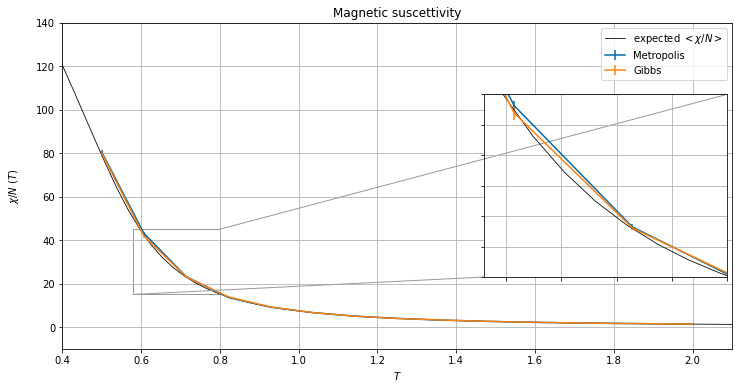

In [181]:
obs_graph("chi")

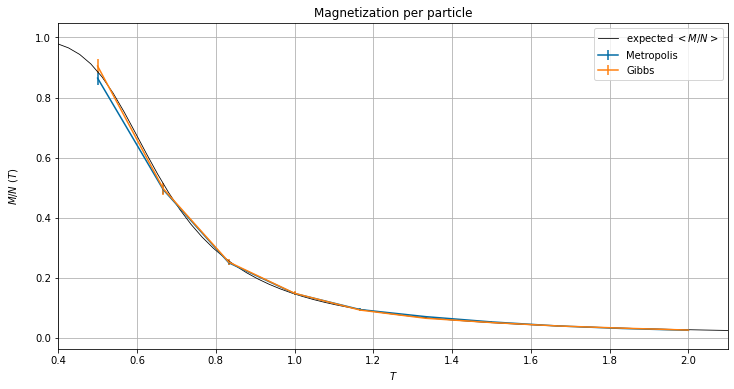

In [156]:
obs_graph("mag")